In [1]:
import pymongo as pm
import gridfs
import cPickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pylab

from scipy import misc
import os
import time

import jupyter_utils as utils
from instance_stats import analysis

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

In [2]:
nearest_list = np.load('/mnt/fs3/azhai/center_cropped_embeddings/ep200_nearest_list.npz')
nearest_dps = nearest_list['highest_dps']
nearest_idxs = nearest_list['highest_dp_indices']
print nearest_dps.shape
print nearest_idxs.shape

(10000, 5000)
(10000, 5000)


In [3]:
data = np.load('/mnt/fs3/azhai/augmentation_cloud/ep200_train0.npz')
aug_emb = data['augmented_embeddings']
center_emb = data['center_crop_embeddings']
print aug_emb.shape, center_emb.shape

(1251, 2000, 128) (1251, 128)


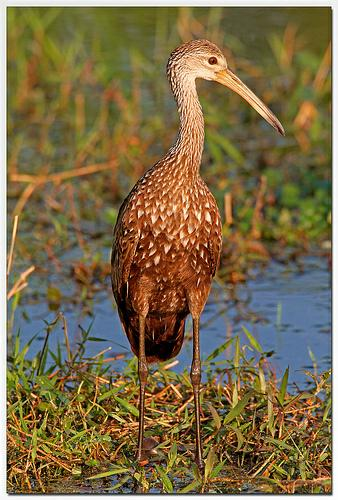

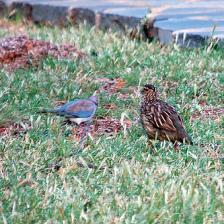

In [5]:
# ImageNet has some duplicate images, e.g. 10 and 42892
os.environ['CUDA_VISIBLE_DEVICES'] = ''
img1 = utils.image_utils.get_training_img_by_index(200)
img2 = utils.image_utils.get_training_img_by_index(42892)
utils.display_img_array(img1.as_tensor(), img2.crop_to_center())

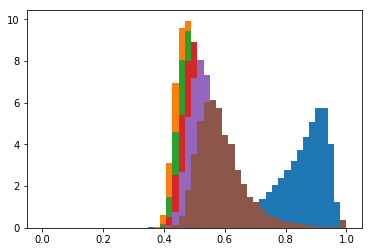

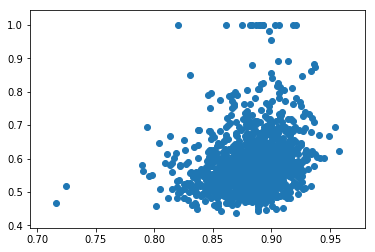

In [53]:
n = len(center_emb)
cloud_means = []
aug_dps = []
for i in range(n):
    dps = np.dot(aug_emb[i], center_emb[i])
    aug_dps.append(dps)
    cloud_means.append(np.mean(aug_emb[i], axis=0))
aug_dps = np.concatenate(aug_dps)

bins = np.linspace(0.0, 1.0, num=50)
plt.hist(aug_dps, bins=bins, density=True)
for i in reversed([1, 3, 6, 10, 15]):
    plt.hist(nearest_dps[:, i], bins=bins, density=True)
plt.show()
    
plt.scatter([np.linalg.norm(x) for x in cloud_means], nearest_dps[:n,1])
plt.show()


In [62]:
def load_trajectories(num_train_files):
    all_trajectories = []
    all_pcas = []
    for i in range(num_train_files):
        trajs = np.load('/mnt/fs3/azhai/trajectories/traj_train%i.npy' % i)
        all_trajectories.append(trajs)
        pcas = np.load('/mnt/fs3/azhai/trajectories/traj_train%i_pca.npy' % i)
        all_pcas.extend(pcas)

    all_trajectories = np.concatenate(all_trajectories, axis=1)
    return all_trajectories, all_pcas

trajectories, _ = load_trajectories(10)
print(trajectories.shape)

(200, 12511, 128)


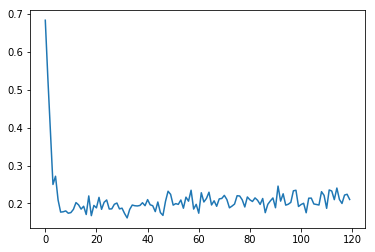

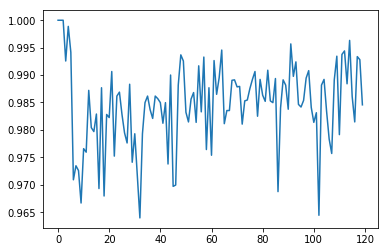

In [61]:
mean_trajectory = np.mean(trajectories, axis=1)
mean_lens = []
mean_seps = []
for i, v in enumerate(mean_trajectory):
    mean_lens.append(np.linalg.norm(v))
    mean_seps.append(analysis.linsep(trajectories[i], v, threshold=0.0))
    
n = len(mean_trajectory)
plt.plot(range(n), mean_lens)
plt.show()
plt.plot(range(n), mean_seps)
plt.show()

<BarContainer object of 10 artists>

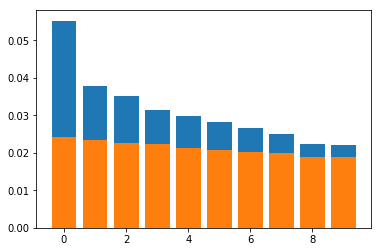

In [52]:
# The mean trajectory seems to jump around randomly
mean_var_weights, _, mean_pca_vecs = analysis.pca_analysis(mean_trajectory[5:])
plt.bar(range(10), mean_var_weights)
random_var_weights, _, _ = analysis.pca_analysis(np.random.randn(len(mean_trajectory), 128))
plt.bar(range(10), random_var_weights)